# CS 3110/3990: Data Privacy
## In-Class Exercise, Week of 9/25/2023

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1

For various values of $b$, write code to print out the percent error of summing the ages in the `adult` dataset, 
clipped to each value of $b$.

In [2]:
bs = range(1, 100, 10)
real_sum = adult['Age'].sum()

for b in bs:
    clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
    print('Percent error, b=', b, ': ', pct_error(real_sum, clipped_sum))

Percent error, b= 1 :  97.4080940444511
Percent error, b= 11 :  71.48903448896206
Percent error, b= 21 :  46.000380495392264
Percent error, b= 31 :  25.509031989473492
Percent error, b= 41 :  11.7959939725709
Percent error, b= 51 :  4.329687317165198
Percent error, b= 61 :  1.1587597123836921
Percent error, b= 71 :  0.2341877497996031
Percent error, b= 81 :  0.03860675005194001
Percent error, b= 91 :  0.0


What value of $b$ is the best?

$b = 91$ because it results in 0 error

## Question 2

For various values of $b$, print the result of a *differentially private* sum of ages, clipped to each value of $b$. Use $\epsilon = 0.1$.

In [4]:
bs = range(1, 100, 10)
real_sum = adult['Age'].sum()

for b in bs:
    clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
    dp_sum = laplace_mech(clipped_sum, b, 0.1)
    print('Percent error, b=', b, ': ', pct_error(real_sum, dp_sum))

Percent error, b= 1 :  97.40803358331216
Percent error, b= 11 :  71.48739342595698
Percent error, b= 21 :  46.005996789192956
Percent error, b= 31 :  25.527706367777224
Percent error, b= 41 :  11.794417684536647
Percent error, b= 51 :  4.437263108713219
Percent error, b= 61 :  1.1823562072606495
Percent error, b= 71 :  0.26182118219685707
Percent error, b= 81 :  0.12972741478458652
Percent error, b= 91 :  0.0625574478897086


Which value of $b$ is the best now? Does it differ?

$b = 91$ , the error is still the lowest

## Question 3

Write an algorithm to *automatically pick the clipping parameter* for the age column. Your algorithm should satisfy differential privacy.

In [5]:
def pick_b(epsilon):
    candidate_bs = range(1, 1000, 50)
    dp_sums = []

    for i in range(len(candidate_bs)):
        candidate_b = candidate_bs[i]
        clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
        dp_sum = laplace_mech(clipped_sum, b, epsilon)
        if i > 1 and abs(dp_sum - dp_sums[-1]) < 50:
            return candidate_b
        else:
            dp_sums.append(dp_sum)
    return candidate_bs[-1]

pick_b(1.0)

151

In [6]:
# TEST CASE for question 3

many_trials = np.mean([pick_b(1.0) for _ in range(100)])
assert many_trials > 70
assert many_trials < 500

## Question 4

What is the privacy cost of your algorithm, and why?

This algorithm performs at most 20 loops of $\epsilon$ privacy cost, resulting in a total privacy cost of $20\epsilon$ privacy cost by sequential composition.

## Question 5

Write code to generate a *histogram* of education numbers in the `adult` dataset.

In [7]:
def education_hist():
    return adult['Education'].value_counts()

education_hist()

Education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [8]:
# TEST CASE for question 5
h = education_hist()
assert h['HS-grad'] == 10501
assert h['12th'] == 433
assert h['Doctorate'] == 413

## Question 6

Write code to release a *differentially private histogram* of education numbers.

In [9]:
def dp_education_hist(epsilon):
    return education_hist().apply(lambda x: laplace_mech(x, 1, epsilon))

dp_education_hist(1.0)

Education
HS-grad         10499.857726
Some-college     7291.492984
Bachelors        5356.469990
Masters          1725.927397
Assoc-voc        1385.012080
11th             1174.610334
Assoc-acdm       1067.352173
10th              933.705299
7th-8th           645.515780
Prof-school       575.309513
9th               514.030597
12th              431.450244
Doctorate         412.176248
5th-6th           332.935597
1st-4th           169.484115
Preschool          52.577056
Name: count, dtype: float64

In [10]:
# TEST CASE for question 6
h = dp_education_hist(1.0)
assert abs(h['HS-grad'] - 10501) < 100
assert abs(h['Doctorate'] - 413) < 100

## Question 7

What is the total privacy cost of `dp_education_hist`, and why?

The total privacy cost is $\epsilon$ by parallel composition.

## Question 8

Write code to generate a differentially private *contingency table* for the Education and Sex columns of the `adult` dataset.

In [11]:
def dp_crosstab_education_sex(epsilon):
    ct = pd.crosstab(adult['Education'], adult['Sex'])
    return ct.applymap(lambda x: laplace_mech(x, 1, epsilon))

dp_crosstab_education_sex(1.0)

Sex,Female,Male
Education,,
10th,294.644124,638.316433
11th,431.592416,742.410009
12th,141.121078,291.829936
1st-4th,45.377628,122.163917
5th-6th,83.118964,248.125885
7th-8th,161.886333,484.674782
9th,142.964677,369.137796
Assoc-acdm,422.920738,643.987425
Assoc-voc,500.104977,885.669524


In [12]:
# TEST CASE for question 8
ct = dp_crosstab_education_sex(1.0)
assert abs(ct['Female']['10th'] - 295) < 100
assert abs(ct['Male']['10th'] - 638) < 100
assert abs(ct['Female']['Bachelors'] - 1619) < 100

assert abs(ct['Female']['10th'] - 295) > 0
assert abs(ct['Male']['10th'] - 638) > 0
assert abs(ct['Female']['Bachelors'] - 1619) > 0

## Question 9

Does parallel composition apply for the contingency table in question 1? Why or why not?

Yes, because each cell is a count over a disjoint group

## Question 10

Does the number of columns used in constructing the contingency table matter for privacy cost? Does it matter for accuracy?

Privacy cost is not affected, but more groups means smaller datasets in each group, reducing accuracy

## Question 11

Implement the Gaussian mechanism for $(\epsilon, \delta)$-differential privacy.

In [13]:
def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

In [14]:
# TEST CASE

results = [gaussian_mech(len(adult[adult['Age'] > 50]), 1, 1.0, 10e-5) for _ in range(100)]
errors = [pct_error(len(adult[adult['Age'] > 50]), r) for r in results]
print('mean error:', np.mean(errors))

assert np.mean(errors) > 0
assert np.mean(errors) < 2

mean error: 0.05246059621529797


## Question 12

How do the Laplace and Gaussian mechanisms compare in terms of relative error on the query "how many individuals are over 50 years old" with $\epsilon = 1$ and $\delta = 10^{-5}$?

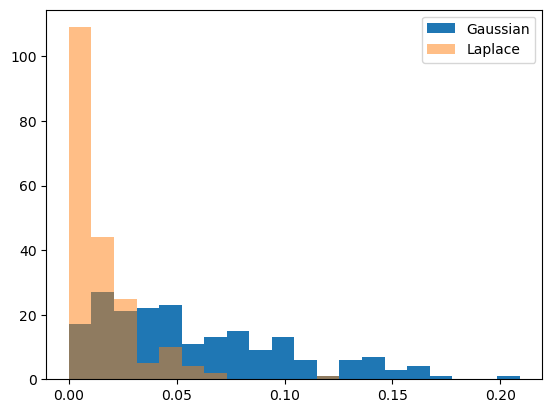

In [15]:
true_answer = len(adult[adult['Age'] > 50])

laplace_answers = [laplace_mech(true_answer, 1, 1) for _ in range(200)]
gaussian_answers = [gaussian_mech(true_answer, 1, 1, 10e-5) for _ in range(200)]

laplace_error = [pct_error(true_answer, a) for a in laplace_answers]
gaussian_error = [pct_error(true_answer, a) for a in gaussian_answers]

_, bins, _ = plt.hist(gaussian_error, bins=20, label='Gaussian')
plt.hist(laplace_error, bins=bins, label='Laplace', alpha=0.5)
plt.legend();

The Laplace mechanism seems better in terms of relative error.

## Not a Question - Just for reference

[Reference](https://uvm-plaid.github.io/programming-dp/notebooks/ch6.html#the-gaussian-mechanism)

e^epsilon = 2.718281828459045


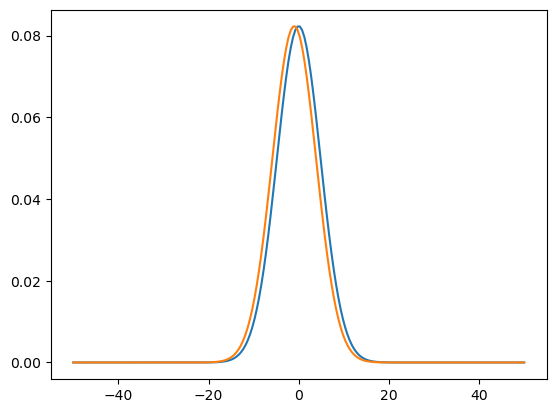

In [16]:
epsilon = 1
sensitivity = 1
delta = 1e-5
sigma_squared = 2 * sensitivity**2 * np.log(1.25 / delta) / (epsilon**2)
sigma = np.sqrt(sigma_squared)

def gauss_pdf(x):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(1/2)*(x/sigma)**2)

xs = np.linspace(-50, 50, 200)
ys1 = [gauss_pdf(x) for x in xs]
ys2 = [gauss_pdf(x+1) for x in xs]

plt.plot(xs,ys1)
plt.plot(xs,ys2)

# ratio < e^epsilon should hold
print('e^epsilon =', np.exp(epsilon))
ratios = [(x, y1 / y2) for x, y1, y2 in zip(xs, ys1, ys2)]
#ratios

e^epsilon = 2.718281828459045


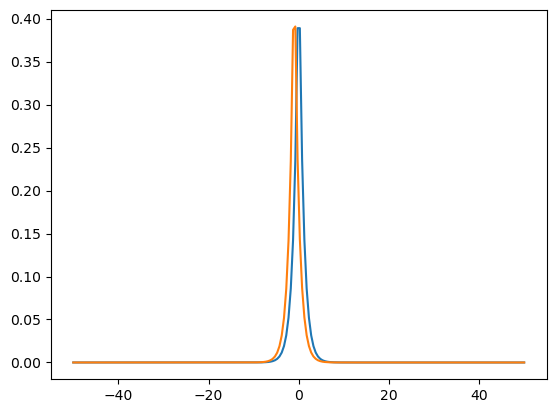

In [17]:
def laplace_pdf(x):
    return (1/2)*epsilon * np.exp(-np.abs(x)*epsilon)

xs = np.linspace(-50, 50, 200)
ys1 = [laplace_pdf(x) for x in xs]
ys2 = [laplace_pdf(x+1) for x in xs]

plt.plot(xs,ys1)
plt.plot(xs,ys2)

# ratio < e^epsilon should hold
print('e^epsilon =', np.exp(epsilon))
ratios = [(x, y1 / y2) for x, y1, y2 in zip(xs, ys1, ys2)]
#ratios